# 	Time Series Forecasting:
Use time series models (e.g., ARIMA, Prophet) to forecast future energy generation based on historical data and weather conditions.

In [12]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

# plotting (optional)
import matplotlib.pyplot as plt

# Try imports for ARIMA auto-selection
use_pmd = True
try:
    from pmdarima import auto_arima
except Exception:
    use_pmd = False

# SARIMAX fallback
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet import (try modern package name)
try:
    from prophet import Prophet
except Exception as e:
    raise ImportError("Prophet is required. Install via `pip install prophet` (or `pip install fbprophet` for older installs).") from e

## 1) Load & prepare daily data

In [ ]:
WEATHER_FEATURES = ["GHI", "temp", "pressure", "humidity", "clouds_all", "wind_speed"]  
TEST_DAYS = 60         # hold out last N days for testing
FORECAST_HORIZON = 124   # forecast horizon when producing future forecast

df = pd.read_csv("D:/Data Science Classes/Machine Learning/Group Assignment/Mock Project/Renewable Energy and Weather Conditions/solar_weather.csv")
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time")

# create hour/month 
df["date"] = df["Time"].dt.date
df["ds_time"] = df["Time"]  # keep original time if needed

# Daily aggregation
daily_target = df.set_index("Time")["Energy delta[Wh]"].resample("D").sum().rename("y")
daily_weather = df.set_index("Time")[WEATHER_FEATURES].resample("D").mean()

data = pd.concat([daily_target, daily_weather], axis=1)
# interpolate small gaps in weather and target if any
data["y"] = data["y"].interpolate(limit_direction="both")
data[WEATHER_FEATURES] = data[WEATHER_FEATURES].interpolate(limit_direction="both")
# If still NaNs (edge cases), forward/backfill
data[WEATHER_FEATURES] = data[WEATHER_FEATURES].fillna(method="ffill").fillna(method="bfill")

# final dataframe
data = data.reset_index().rename(columns={"Time": "ds"})  # ds is date for Prophet

In [14]:
data

,ds,y,GHI,temp,pressure,humidity,clouds_all,wind_speed
0,2017-01-01,2039,2.138542,2.975000,1015.000000,94.375000,99.333333,5.695833
1,2017-01-02,10307,4.201042,0.850000,1012.833333,92.333333,57.166667,4.750000
2,2017-01-03,2256,2.444792,1.420833,1008.458333,96.083333,95.250000,6.708333
3,2017-01-04,3948,2.998958,1.166667,996.666667,83.875000,71.541667,8.375000
4,2017-01-05,0,4.441146,0.329861,999.902778,84.020833,63.451389,7.847222
...,...,...,...,...,...,...,...,...
2064,2022-08-27,96183,48.619792,21.191667,1011.250000,79.833333,71.250000,2.762500
2065,2022-08-28,19886,15.205208,18.829167,1014.333333,89.125000,75.333333,3.662500
2066,2022-08-29,41137,22.509375,16.525000,1017.833333,87.416667,64.791667,3.820833
2067,2022-08-30,80660,44.614583,16.191667,1022.125000,81.625000,67.333333,2.862500


## 2) Train/test split (time-based)

In [15]:
train = data.iloc[:-TEST_DAYS].copy()
test = data.iloc[-TEST_DAYS:].copy()

print(f"Data range: {data['ds'].min().date()} -> {data['ds'].max().date()}")
print(f"Train: {train['ds'].min().date()} -> {train['ds'].max().date()} ({len(train)} days)")
print(f"Test:  {test['ds'].min().date()} -> {test['ds'].max().date()} ({len(test)} days)")

# -------------------------------
# Helper: evaluation
# -------------------------------
def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {"RMSE": float(rmse), "MAE": float(mae)}

results = {}

Data range: 2017-01-01 -> 2022-08-31
Train: 2017-01-01 -> 2022-07-02 (2009 days)
Test:  2022-07-03 -> 2022-08-31 (60 days)


## 3) ARIMA / SARIMAX (with exogenous)

In [16]:
print("\n>>> Fitting ARIMA/SARIMAX (with exogenous weather features)")
exog_train = train[WEATHER_FEATURES].values
exog_test = test[WEATHER_FEATURES].values

# Ensure no NaNs in exog
imputer = SimpleImputer(strategy="mean")
exog_train = imputer.fit_transform(exog_train)
exog_test = imputer.transform(exog_test)

arima_model_obj = None
arima_name = "SARIMAX_fallback"

if use_pmd:
    try:
        print(" - Using pmdarima.auto_arima to select orders (may take time)...")
        aa = auto_arima(train["y"].values, seasonal=True, m=365, exogenous=exog_train,
                        stepwise=True, suppress_warnings=True, max_p=6, max_q=6, trace=False)
        order = aa.order
        seasonal_order = aa.seasonal_order
        print(f" - auto_arima suggested order={order} seasonal_order={seasonal_order}")
        # Fit SARIMAX with those orders
        arima_model_obj = SARIMAX(train["y"].values, exog=exog_train,
                                  order=order, seasonal_order=seasonal_order,
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        arima_name = f"SARIMAX_{order}_{seasonal_order}"
    except Exception as e:
        print(" - auto_arima failed or incompatible; falling back to preset SARIMAX.")
        use_pmd = False

if not use_pmd:
    # fallback order (commonly reasonable starting point)
    order = (5,1,1)
    seasonal_order = (1,1,1,7)  # weekly seasonality as fallback
    print(f" - Using fallback SARIMAX order={order} seasonal_order={seasonal_order}")
    arima_model_obj = SARIMAX(train["y"].values, exog=exog_train,
                              order=order, seasonal_order=seasonal_order,
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    arima_name = f"SARIMAX_{order}_{seasonal_order}"

# Forecast for test period
arima_forecast = arima_model_obj.get_forecast(steps=len(test), exog=exog_test)
arima_pred = arima_forecast.predicted_mean
# convert to numpy array to align
arima_pred = np.array(arima_pred).ravel()

arima_metrics = eval_metrics(test["y"].values, arima_pred)
results[arima_name] = arima_metrics
print(f"ARIMA {arima_name} -> RMSE: {arima_metrics['RMSE']:.2f}, MAE: {arima_metrics['MAE']:.2f}")


>>> Fitting ARIMA/SARIMAX (with exogenous weather features)
 - Using fallback SARIMAX order=(5, 1, 1) seasonal_order=(1, 1, 1, 7)
ARIMA SARIMAX_(5, 1, 1)_(1, 1, 1, 7) -> RMSE: 22001.83, MAE: 17121.62


## 4) Prophet with regressors

In [17]:
print("\n>>> Fitting Prophet (with regressors)")
# Prophet expects dataframe with columns ds and y
prophet_train = train[["ds", "y"] + WEATHER_FEATURES].copy()
prophet_test = test[["ds", "y"] + WEATHER_FEATURES].copy()

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
# add regressors
for r in WEATHER_FEATURES:
    m.add_regressor(r)

# Fit
m.fit(prophet_train)

# build future for test period using test regressors
future = prophet_test[["ds"] + WEATHER_FEATURES].copy()
fcst = m.predict(future)
prophet_pred = fcst["yhat"].values

prophet_metrics = eval_metrics(test["y"].values, prophet_pred)
results["Prophet_with_regressors"] = prophet_metrics
print(f"Prophet -> RMSE: {prophet_metrics['RMSE']:.2f}, MAE: {prophet_metrics['MAE']:.2f}")


>>> Fitting Prophet (with regressors)


20:50:17 - cmdstanpy - INFO - Chain [1] start processing
20:50:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> RMSE: 20377.14, MAE: 12179.12


## 5) Compare & pick best

In [18]:
results_df = pd.DataFrame(results).T
results_df = results_df.assign(RMSE_rank=results_df["RMSE"].rank(), MAE_rank=results_df["MAE"].rank())
print("\n=== Model comparison ===")
print(results_df.sort_values("RMSE"))

best_model_key = results_df["RMSE"].idxmin()
print(f"\nBest model by RMSE: {best_model_key}")


=== Model comparison ===
                                        RMSE           MAE  RMSE_rank  \
Prophet_with_regressors         20377.144018  12179.123780        1.0   
SARIMAX_(5, 1, 1)_(1, 1, 1, 7)  22001.825634  17121.623085        2.0   

                                MAE_rank  
Prophet_with_regressors              1.0  
SARIMAX_(5, 1, 1)_(1, 1, 1, 7)       2.0  

Best model by RMSE: Prophet_with_regressors


## 6) Retrain best model on FULL DATA and save

In [19]:
print("\n>>> Retraining best model on full data and saving...")

full_exog = data[WEATHER_FEATURES].values
full_exog = imputer.fit_transform(full_exog)  # refit imputer on full exog

if best_model_key.startswith("SARIMAX"):
    # retrain SARIMAX on full y + exog
    # reuse earlier chosen order/seasonal_order variables where applicable
    # If auto_arima used, arima_model_obj contains the chosen order; else we have fallback order
    # We will re-use order and seasonal_order variables defined earlier
    sarimax_full = SARIMAX(data["y"].values, exog=full_exog,
                           order=order, seasonal_order=seasonal_order,
                           enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    # Save
    joblib.dump({"model": sarimax_full, "type": "sarimax", "order": order, "seasonal_order": seasonal_order,
                 "features": WEATHER_FEATURES}, f"best_ts_model_{best_model_key}.pkl")
    print(f"Saved SARIMAX model to best_ts_model_{best_model_key}.pkl")

elif best_model_key == "Prophet_with_regressors":
    # retrain Prophet on full data
    prophet_full_df = data[["ds", "y"] + WEATHER_FEATURES].copy()
    m_full = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    for r in WEATHER_FEATURES:
        m_full.add_regressor(r)
    m_full.fit(prophet_full_df)
    joblib.dump({"model": m_full, "type": "prophet", "features": WEATHER_FEATURES}, f"best_ts_model_{best_model_key}.pkl")
    print(f"Saved Prophet model to best_ts_model_{best_model_key}.pkl")

else:
    print("Best model type unrecognized; not saved automatically.")

# Save results table
results_df.to_csv(RESULTS_CSV, index=True)
print(f"\nSaved model comparison results to {RESULTS_CSV}")


>>> Retraining best model on full data and saving...


20:50:18 - cmdstanpy - INFO - Chain [1] start processing
20:50:18 - cmdstanpy - INFO - Chain [1] done processing


Saved Prophet model to best_ts_model_Prophet_with_regressors.pkl

Saved model comparison results to ts_model_comparison_results.csv


## 7) Produce a short future forecast from the saved best model (optional)

In [20]:
# -------------------------------
# 7) Produce a short future forecast from the saved best model (optional)
# -------------------------------
print("\n>>> Producing a {FORECAST_HORIZON}-day future forecast with the selected model (using latest weather averages).")
future_dates = pd.date_range(start=data["ds"].max() + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq="D")

# For exogenous future weather you need to provide forecasts; here we use last observed daily mean as a simple proxy (repeat last day)
last_weather = data[WEATHER_FEATURES].iloc[-1:].values
future_exog = np.repeat(last_weather, FORECAST_HORIZON, axis=0)

if best_model_key.startswith("SARIMAX"):
    # use sarimax_full to forecast
    pred_future = sarimax_full.get_forecast(steps=FORECAST_HORIZON, exog=future_exog).predicted_mean
    fc_df = pd.DataFrame({"ds": future_dates, "yhat": np.array(pred_future).ravel()})
elif best_model_key == "Prophet_with_regressors":
    # build future df and fill regressors with last observed (simple approach)
    future_prophet = pd.DataFrame({"ds": future_dates})
    for i, r in enumerate(WEATHER_FEATURES):
        future_prophet[r] = last_weather[0, i]
    fc_df = pd.DataFrame({"ds": future_dates, "yhat": m_full.predict(future_prophet)["yhat"].values})
else:
    fc_df = pd.DataFrame({"ds": future_dates, "yhat": np.nan})

print(fc_df.head())



>>> Producing a {FORECAST_HORIZON}-day future forecast with the selected model (using latest weather averages).
          ds           yhat
0 2022-09-01  124130.637212
1 2022-09-02  125711.267897
2 2022-09-03  125739.483106
3 2022-09-04  125112.528748
4 2022-09-05  125575.187410


## 8) Quick plot comparing test actuals and predictions (for the two models)

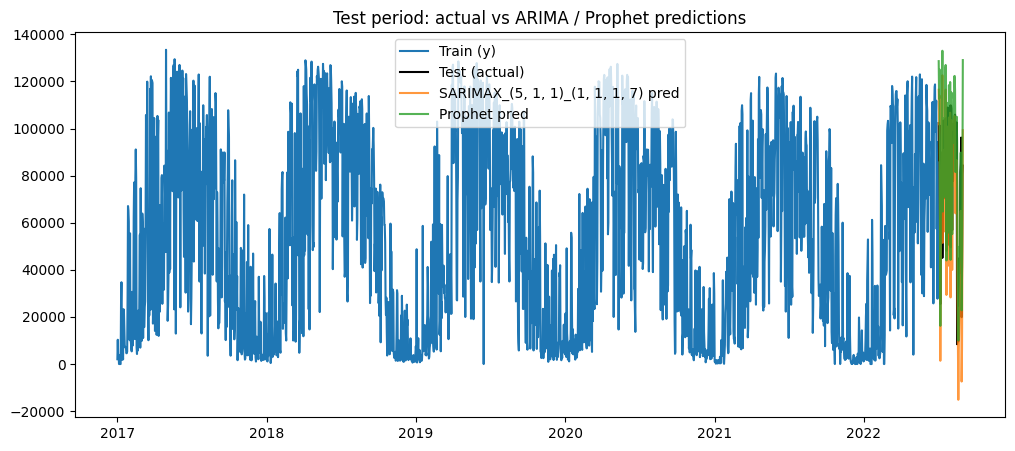

In [21]:
plt.figure(figsize=(12,5))
plt.plot(train["ds"], train["y"], label="Train (y)")
plt.plot(test["ds"], test["y"], label="Test (actual)", color="black")
plt.plot(test["ds"], arima_pred, label=f"{arima_name} pred", alpha=0.8)
plt.plot(test["ds"], prophet_pred, label="Prophet pred", alpha=0.8)
plt.legend(); plt.title("Test period: actual vs ARIMA / Prophet predictions"); plt.show()